In [2]:
# See http://stackoverflow.com/questions/27004422/contour-imshow-plot-for-irregular-x-y-z-data
%pylab inline
import scipy as sp
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [3]:
def get_grid(x_limits, y_limits, step=.01):
    return np.meshgrid(np.arange(*x_limits, step=step),
                       np.arange(*y_limits, step=step))

In [50]:
def plot_func_tricontourf(func, grid, draw_points=True):
    xx, yy = grid
    xx, yy = xx.ravel(), yy.ravel()
    predicted = func(xx, yy)
    plt.tricontourf(xx, yy, predicted, 20)
    if draw_points:
        plt.scatter(xx.ravel(), yy.ravel())
        
def plot_func_griddata(func, grid, draw_points=True):
    xx, yy = grid
    predicted = func(xx, yy)
    plt.pcolormesh(xx, yy, predicted)
    if draw_points:
        plt.scatter(xx.ravel(), yy.ravel())

Wall time: 27.5 s


F:\Anaconda3\lib\site-packages\matplotlib\tri\triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)


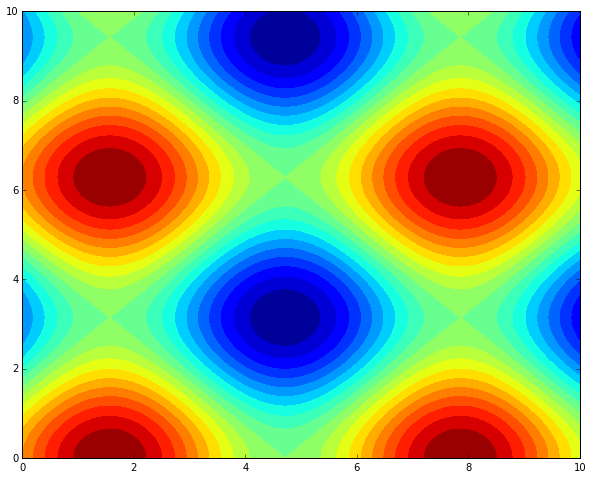

In [33]:
grid = get_grid((0, 10), (0, 10), 0.01)
%time plot = plot_func_tricontourf(lambda x, y: np.sin(x) + np.cos(y), grid, False)
plot

Wall time: 208 ms


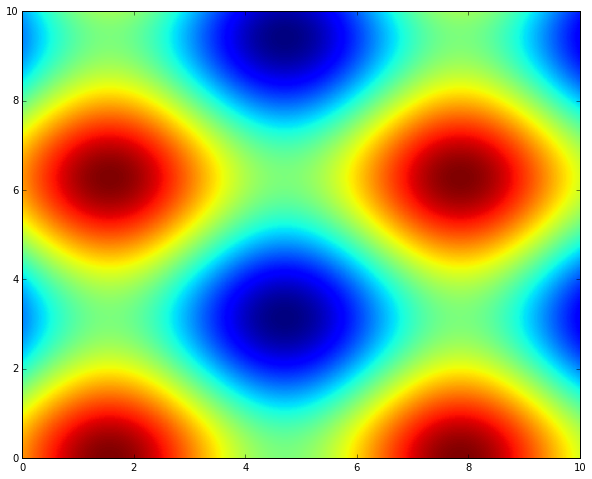

In [51]:
grid = get_grid((0, 10), (0, 10), 0.01)
%time plot = plot_func_griddata(lambda x, y: np.sin(x) + np.cos(y), grid, False)
plot

In [88]:
def dgrid(func, x_limits, y_limits, initial_step, min_step=0.001, max_diff=0.01):
    x_step = initial_step
    y_step = initial_step
    xx, yy = np.meshgrid(np.arange(*x_limits, step=x_step),
                       np.arange(*y_limits, step=y_step))
    rez_xx, rez_yy = xx.ravel(), yy.ravel()
    values = func(xx, yy)
    top_left = values[:-1, :-1].ravel()
    top_right = values[:-1, 1:].ravel()
    bottom_left = values[1:, :-1].ravel()
    bottom_right = values[1:, 1:].ravel()
    
    corners_x = xx[:-1, :-1].ravel()
    corners_y = yy[:-1, :-1].ravel()
    
    def process_segment(top_left_corner_x, top_left_corner_y,
                        x_size, y_size,
                        top_left_value=None,
                        top_right_value=None,
                        bottom_left_value=None,
                        bottom_right_value=None,
                        return_right_border=False,
                        return_bottom_border=False,
                       ):
        if top_left_value is None:
            top_left_value = func(top_left_corner_x, top_left_corner_y)
        if top_right_value is None:
            top_right_value = func(top_left_corner_x + x_size, top_left_corner_y)
        if bottom_left_value is None:
            bottom_left_value = func(top_left_corner_x, top_left_corner_y + y_size)
        if bottom_right_value is None:
            bottom_right_value = func(top_left_corner_x + x_size, top_left_corner_y + y_size)
        values = [top_left_value, top_right_value, bottom_left_value, bottom_right_value]
        patch_max_diff = np.max(values) - np.min(values)
        if (patch_max_diff < max_diff
            or x_size < 2 * min_step
            or y_size < 2 * min_step):
            x_points = [top_left_corner_x]
            # TODO sort out tricky logic with borders
            return [top_left_corner_x], [top_left_corner_y], [top_left_value]
        x_subsegment_size = x_size / 2
        y_subsegment_size = y_size / 2
        return np.concatenate([
                process_segment(
                    top_left_corner_x, top_left_corner_y,
                    x_subsegment_size, y_subsegment_size,
                    top_left_value=top_left_value,
                ),
                process_segment(
                    top_left_corner_x + x_subsegment_size,
                    top_left_corner_y,
                    x_size - x_subsegment_size,
                    y_subsegment_size,
                    top_right_value=top_right_value,
                    return_right_border=return_right_border,
                ),
                process_segment(
                    top_left_corner_x,
                    top_left_corner_y + y_subsegment_size,
                    x_subsegment_size,
                    y_size - y_subsegment_size,
                    bottom_left_value=bottom_left_value,
                    return_bottom_border=return_bottom_border,
                ),
                process_segment(
                    top_left_corner_x + x_subsegment_size,
                    top_left_corner_y + y_subsegment_size,
                    x_size - x_subsegment_size,
                    y_size - y_subsegment_size,
                    bottom_right_value=bottom_right_value,
                    return_right_border=return_right_border,
                    return_bottom_border=return_bottom_border,
                ),
            ],
            axis=1)
            
    result_x, result_y, result_f = np.concatenate(
        [process_segment(corner_x, corner_y, x_step, y_step, tl, tr, bl, br,)
         for corner_x, corner_y, tl, tr, bl, br in zip(
            corners_x, corners_y, top_left, top_right, bottom_left, bottom_right)],
        axis=1
    )
    return result_x, result_y, result_f

Wall time: 0 ns


F:\Anaconda3\lib\site-packages\matplotlib\tri\triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)


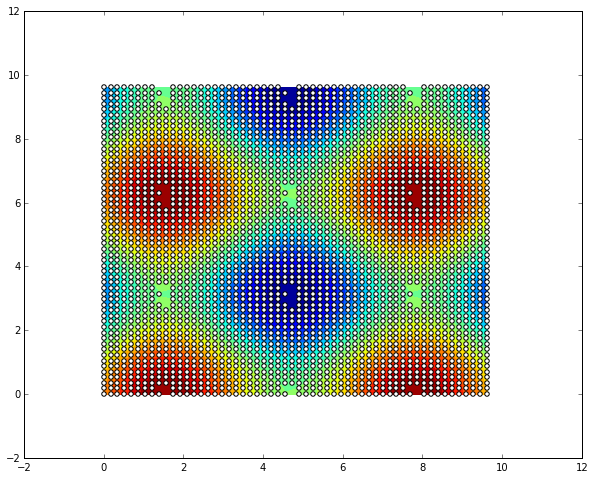

In [90]:
%time
func = lambda x, y: np.sin(x) + np.cos(y)
xx, yy, zz = dgrid(func, (0, 10), (0, 10), 0.7, max_diff=0.1, min_step=0.1)
plt.tricontourf(xx, yy, zz, 20)
plt.scatter(xx, yy, c='w')

F:\Anaconda3\lib\site-packages\ipykernel\__main__.py:34: DeprecationWarning: numpy boolean subtract (the binary `-` operator) is deprecated, use the bitwise_xor (the `^` operator) or the logical_xor function instead.
F:\Anaconda3\lib\site-packages\matplotlib\tri\triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)


Wall time: 0 ns


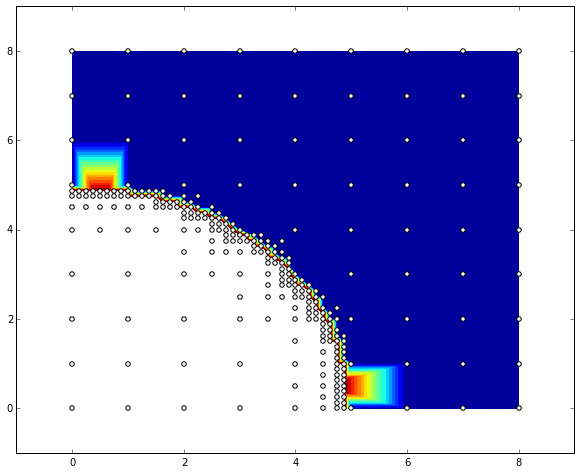

In [76]:
%time
func = lambda x, y: np.sin(x) + np.cos(y)  
func = lambda x, y: x**2 + y**2 < 25
xx, yy, zz = dgrid(func, (0, 10), (0, 10), 1, max_diff=0.01, min_step=0.1)
plt.tricontourf(xx, yy, zz, 20)
plt.scatter(xx, yy, c='w')